## Model discrimination via genetic algorithm

In [12]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.integrate import odeint
import pandas as pd

# Candidate term names
term_names = [
    "Monod Growth",
    "Hill Kinetics Growth",
    "Substrate Inhibition Factor",
    "Product Inhibition Factor (Competitive)",
    "Non-Competitive Product Inhibition",
    "Competitive Inhibition Factor",
    "Double Substrate Limited Factor",
    "Substrate Threshold Activation",
    "Substrate-Product Interaction",
    "Inhibitor Saturation",
    "Cell Death/Maintenance Energy"
]

# Define the true model (students won't know this)
def true_model(y, t, S0, I0):
    X, S, P, I = y  # X: biomass, S: substrate, P: product, I: inhibitor
    
    # True mechanism: Monod growth with product inhibition
    mu_max = 0.5
    Ks = 2.0
    Ki = 1.0
    Yxs = 0.4
    
    # Growth terms multiplied together
    growth = mu_max * (S / (Ks + S)) * (Ki / (Ki + P)) * X
    
    dX = growth
    dS = -(growth/Yxs)
    dP = 0.3 * growth
    dI = -0.1 * I
    
    return [dX, dS, dP, dI]


# Define candidate terms that students will use
def candidate_models(y, t, params, mask):
    X, S, P, I = y
    mu_max, Ks, Ki, Yxs, Kp = params

    # Base growth
    growth = mu_max * X

    # Monod Growth (mask[0])
    if mask[0]:
        growth *= S / (Ks + S)

    # Hill Kinetics Growth (mask[1])
    if mask[1]:  # Hill Kinetics
        n = 2  # Hill coefficient (can be made tunable)
        growth *= S**n / (Ks**n + S**n)

    # Substrate Inhibition Factor (mask[2])
    if mask[2]:
        growth *= 1 / (1 + S / Ki)

    # Product Inhibition Factor (mask[3]) (Competitive Inhibition)
    if mask[3]:
        growth *= Ki / (Ki + P)

    # Non-Competitive Product Inhibition (mask[4])
    if mask[4]:
        growth *= 1 / (1 + P / Kp)

    # Competitive Inhibition Factor (mask[5])
    if mask[5]:
        growth *= 1 / (1 + I / Ki)

    # Double Substrate Limited Factor (mask[6])
    if mask[6]:
        growth *= I / (Ki + I)

    # Substrate Threshold Activation (mask[7])
    if mask[7]:
        S_threshold = 0.5  # Tunable threshold
        growth *= 1 if S > S_threshold else 0

    # Substrate-Product Interaction (mask[8])
    if mask[8]:
        growth *= (S / (Ks + S)) * (1 / (1 + P / Kp))

    # Inhibitor Saturation (mask[9])
    if mask[9]:  # Hill-like inhibitor saturation
        n_inhibitor = 1  # Hill coefficient for inhibition
        growth *= 1 / (1 + (I / Ki)**n_inhibitor)

    # Derivatives
    dX = growth
    dS = -(growth / Yxs)
    dP = 0.3 * growth
    dI = -0.1 * I

    return [dX, dS, dP, dI]


def generate_training_data(n_experiments=3, n_timepoints=20, noise_level=0.05):
    t = np.linspace(0, 10, n_timepoints)
    training_data = []
    
    initial_conditions = [
        [0.1, 10.0, 0.0, 1.0],  # Low X, high S
        [0.2, 8.0, 0.0, 2.0],   # Medium X, medium S
        [0.3, 6.0, 0.0, 0.5],   # High X, low S
    ]
    
    # Create lists to store data for DataFrame
    all_times = []
    all_X = []
    all_S = []
    all_P = []
    all_I = []
    experiment_ids = []
    initial_X = []
    initial_S = []
    initial_I = []
    
    for i in range(n_experiments):
        y0 = initial_conditions[i]
        # Generate clean data
        solution = odeint(true_model, y0, t, args=(y0[1], y0[3]))
        
        # Add noise
        noise = np.random.normal(0, noise_level, solution.shape)
        noisy_data = solution + noise * solution
        
        # Store data for DataFrame
        all_times.extend(t)
        all_X.extend(noisy_data[:, 0])
        all_S.extend(noisy_data[:, 1])
        all_P.extend(noisy_data[:, 2])
        all_I.extend(noisy_data[:, 3])
        experiment_ids.extend([i+1] * len(t))
        initial_X.extend([y0[0]] * len(t))
        initial_S.extend([y0[1]] * len(t))
        initial_I.extend([y0[3]] * len(t))
        
        # Store original format for internal use
        training_data.append({
            't': t,
            'data': noisy_data,
            'initial_conditions': y0
        })
    
    # Create DataFrame
    df = pd.DataFrame({
        'time': all_times,
        'experiment': experiment_ids,
        'biomass': all_X,
        'substrate': all_S,
        'product': all_P,
        'inhibitor': all_I,
        'initial_biomass': initial_X,
        'initial_substrate': initial_S,
        'initial_inhibitor': initial_I
    })
    
    return training_data, df


def generate_test_data():
    t = np.linspace(0, 15, 30)  # Longer time period
    test_data = []
    
    test_conditions = [
        [0.05, 15.0, 0.0, 2.5],  # Very low X, very high S
        [0.4, 3.0, 0.0, 0.2],    # Very high X, very low S
    ]
    
    for y0 in test_conditions:
        solution = odeint(true_model, y0, t, args=(y0[1], y0[3]))
        test_data.append({
            't': t,
            'data': solution,
            'initial_conditions': y0
        })
    
    return test_data


def fitness_function(mask, params, training_data):
    total_error = 0
    n_active_terms = sum(mask)
    
    errors_by_experiment = []  # Track errors for each experiment
    for experiment in training_data:
        t = experiment['t']
        y_true = experiment['data']
        y0 = experiment['initial_conditions']
        
        try:
            y_pred = odeint(lambda y, t: candidate_models(y, t, params, mask), y0, t)
            error = np.mean((y_true - y_pred) ** 2)
            total_error += error
            errors_by_experiment.append(error)
        except:
            return float('-inf'), None
    
    # Reduced complexity penalty - it might have been too strong
    complexity_penalty = 0.05 * n_active_terms
    
    return -(total_error + complexity_penalty), errors_by_experiment


# Genetic algorithm
def genetic_algorithm(training_data, generations=10, population_size=50, mutation_rate=0.1):
    n_params = 5
    
    # Initialize population with reasonable parameter ranges
    population = [
        {
            "mask": np.random.randint(0, 2, size=len(term_names)),
            "params": [
                np.random.uniform(0.1, 1.0),    # mu_max
                np.random.uniform(0.5, 5.0),    # Ks
                np.random.uniform(0.5, 5.0),    # Ki
                np.random.uniform(0.2, 0.8),    # Yxs
                np.random.uniform(0.5, 5.0),    # Kp
            ]
        }
        for _ in range(population_size)
    ]
    
     
    best_fitness = float('-inf')
    best_individual = None
    best_errors = None
    
    # Lists to track evolution
    fitness_history = []
    param_history = []
    
    for gen in range(generations):
        # Evaluate fitness
        fitness_and_errors = [
            fitness_function(ind["mask"], ind["params"], training_data)
            for ind in population
        ]
        fitness = [f[0] for f in fitness_and_errors]
        errors = [f[1] for f in fitness_and_errors]
        
        # Update best individual
        current_best = max(fitness)
        current_best_idx = np.argmax(fitness)
        
        if current_best > best_fitness:
            best_fitness = current_best
            best_individual = population[current_best_idx].copy()
            best_errors = errors[current_best_idx]
            
            # Print detailed information
            print(f"\nGeneration {gen}")
            print(f"New best fitness: {best_fitness}")
            print("Parameters:", best_individual["params"])
            print("Active terms:", [term_names[i] for i, m in enumerate(best_individual["mask"]) if m])
            if best_errors:
                print("Errors by experiment:", best_errors)
        
        # Track history
        fitness_history.append(best_fitness)
        param_history.append(best_individual["params"].copy() if best_individual else None)
        
        # Selection - keep top 50%
        sorted_indices = np.argsort(fitness)[::-1]
        population = [population[i] for i in sorted_indices[:population_size//2]]
        
        # Create new population
        new_population = []
        for i in range(population_size // 2):
            # Select parents
            parent1, parent2 = np.random.choice(population, 2, replace=False)
            
            # Create child
            child_mask = np.array([
                np.random.choice([parent1["mask"][j], parent2["mask"][j]])
                for j in range(len(term_names))
            ])
            
            # Parameter crossover with more controlled ranges
            child_params = []
            for p1, p2 in zip(parent1["params"], parent2["params"]):
                param = np.random.uniform(min(p1, p2), max(p1, p2))
                child_params.append(param)
            
            # Mutation
            if np.random.rand() < mutation_rate:
                child_mask[np.random.randint(0, len(term_names))] ^= 1
                param_idx = np.random.randint(0, n_params)
                child_params[param_idx] *= np.random.uniform(0.8, 1.2)
            
            new_population.append({"mask": child_mask, "params": child_params})
        
        population.extend(new_population)
        
        # Every 10 generations, print detailed summary
        if gen % 10 == 0:
            print(f"\nGeneration {gen} summary:")
            print(f"Best fitness: {best_fitness}")
            if best_individual:
                print("Current best parameters:", best_individual["params"])
                current_errors = fitness_function(best_individual["mask"], 
                                               best_individual["params"], 
                                               training_data)[1]
                if current_errors:
                    print("Current errors by experiment:", current_errors)
    
    # Plot fitness history
    plt.figure(figsize=(10, 6))
    plt.plot(fitness_history)
    plt.xlabel('Generation')
    plt.ylabel('Best Fitness')
    plt.title('Fitness Evolution')
    plt.grid(True)
    plt.show()
    
    # Plot parameter evolution
    param_history = np.array(param_history)
    plt.figure(figsize=(12, 8))
    param_names = ['mu_max', 'Ks', 'Ki', 'Yxs', 'Kp']
    for i in range(n_params):
        plt.plot(param_history[:, i], label=param_names[i])
    plt.xlabel('Generation')
    plt.ylabel('Parameter Value')
    plt.title('Parameter Evolution')
    plt.legend()
    plt.grid(True)
    plt.show()
    
    return best_individual


def evaluate_student_solution(mask, params, test_data):
    """
    Evaluate a student's solution on the test dataset.
    
    Parameters:
    mask (list): Binary list indicating which terms are active
    params (list): List of parameter values [mu_max, Ks, Ki, Yxs, Kp]
    test_data (list): List of test experiments
    
    Returns:
    float: RMSE across all test experiments
    dict: Detailed metrics for each variable
    """
    total_squared_error = 0
    n_points = 0
    errors_by_variable = {
        'biomass': [],
        'substrate': [],
        'product': [],
        'inhibitor': []
    }
    
    predictions = []
    
    for exp in test_data:
        t = exp['t']
        y_true = exp['data']
        y0 = exp['initial_conditions']
        
        try:
            y_pred = odeint(lambda y, t: candidate_models(y, t, params, mask), y0, t)
            predictions.append({
                't': t,
                'prediction': y_pred,
                'initial_conditions': y0
            })
            
            # Calculate errors for each variable
            for i, var in enumerate(['biomass', 'substrate', 'product', 'inhibitor']):
                mse = np.mean((y_true[:, i] - y_pred[:, i]) ** 2)
                rmse = np.sqrt(mse)
                errors_by_variable[var].append(rmse)
            
            total_squared_error += np.sum((y_true - y_pred) ** 2)
            n_points += y_true.size
            
        except:
            return float('inf'), None, None
    
    overall_rmse = np.sqrt(total_squared_error / n_points)
    
    # Calculate average RMSE for each variable
    variable_rmse = {var: np.mean(errors) for var, errors in errors_by_variable.items()}
    
    return overall_rmse, variable_rmse, predictions


def plot_results(training_data, test_data, best_individual, test_predictions=None):
    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    variables = ['Biomass', 'Substrate', 'Product', 'Inhibitor']
    
    for var_idx, (ax, var_name) in enumerate(zip(axes.flat, variables)):
        # Plot training data
        for exp in training_data:
            ax.scatter(exp['t'], exp['data'][:, var_idx], 
                      alpha=0.5, label='Training')
        
        # Plot test data
        for exp in test_data:
            ax.plot(exp['t'], exp['data'][:, var_idx], 
                   'r-', alpha=0.5, label='Test')
            
        # Plot predictions for training data
        for exp in training_data:
            t = exp['t']
            y0 = exp['initial_conditions']
            y_pred = odeint(lambda y, t: candidate_models(y, t, best_individual["params"], 
                                                        best_individual["mask"]), y0, t)
            ax.plot(t, y_pred[:, var_idx], 'g--', alpha=0.5, label='Training Prediction')
        
        # Plot predictions for test data if available
        if test_predictions:
            for pred in test_predictions:
                ax.plot(pred['t'], pred['prediction'][:, var_idx], 
                       'b--', alpha=0.5, label='Test Prediction')
        
        ax.set_xlabel('Time')
        ax.set_ylabel(var_name)
        if var_idx == 0:  # Only show legend for first plot to avoid clutter
            ax.legend()
    
    plt.tight_layout()
    plt.show()


Generation 0
New best fitness: -0.9668681833321454
Parameters: [0.5533557769062002, 4.577662390229181, 4.852017204628061, 0.6692550670345337, 3.9936189479102153]
Active terms: ['Monod Growth (S1)', 'Substrate Threshold Activation']
Errors by experiment: [0.20563165632713815, 0.3100799769176496, 0.35115655008735774]

Generation 0 summary:
Best fitness: -0.9668681833321454
Current best parameters: [0.5533557769062002, 4.577662390229181, 4.852017204628061, 0.6692550670345337, 3.9936189479102153]
Current errors by experiment: [0.20563165632713815, 0.3100799769176496, 0.35115655008735774]

Generation 2
New best fitness: -0.6036450511277422
Parameters: [0.5802101152834481, 1.9785483356169162, 3.2717378047137773, 0.5135498717446007, 2.5145453187482105]
Active terms: ['Monod Growth (S1)', 'Inhibitor Saturation']
Errors by experiment: [0.20567154414633232, 0.15660406115805492, 0.14136944582335506]

Generation 3
New best fitness: -0.3794065222602767
Parameters: [0.5648090485818811, 2.6172533086

/var/folders/9g/r1rd7tg91h19l764y_wt09cw0000gn/T/ipykernel_56016/3718190307.py:197: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  y_pred = odeint(lambda y, t: candidate_models(y, t, params, mask), y0, t)


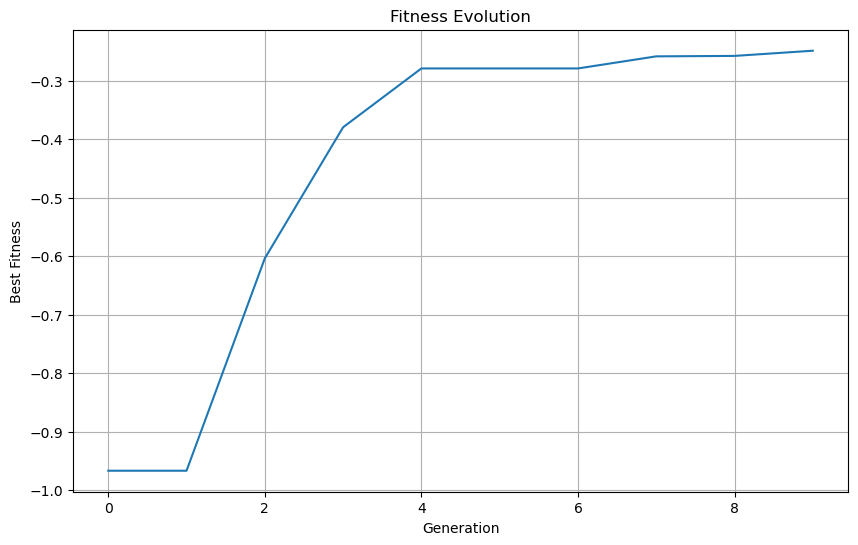

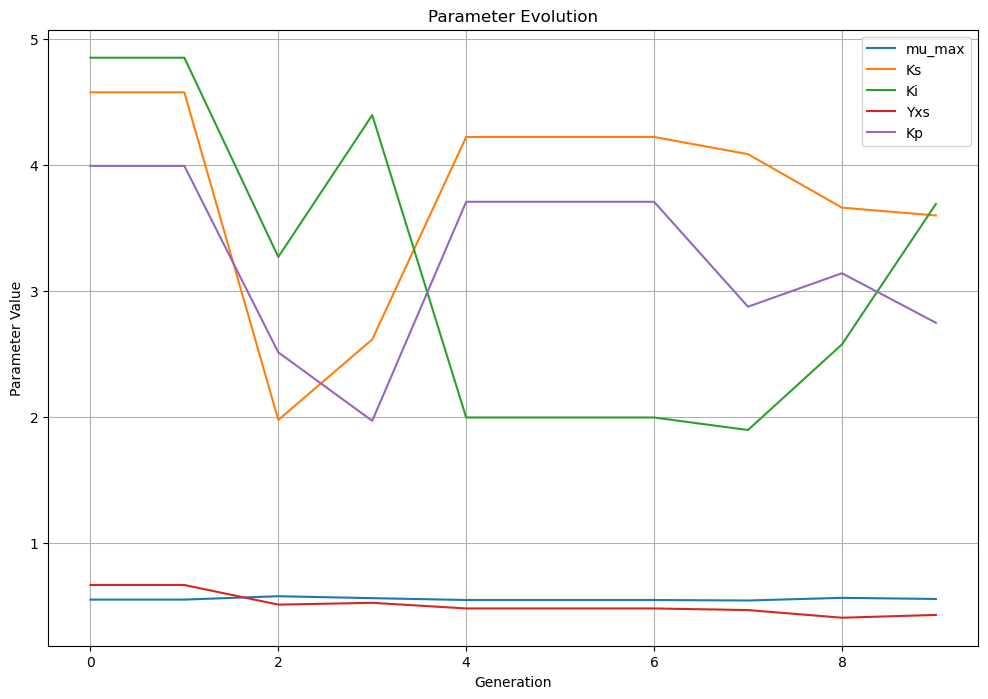


Chosen Terms:
- Monod Growth (S1)
- Non-Competitive Product Inhibition
- Substrate Threshold Activation

Best Parameters: [0.5584727978154822, 3.6008557000726564, 3.69157017251242, 0.4317540018951165, 2.749557135193431]

Test Data Performance:
Overall RMSE: 1.4848

RMSE by variable:
biomass: 0.6816
substrate: 2.6343
product: 0.1990
inhibitor: 0.0208


/var/folders/9g/r1rd7tg91h19l764y_wt09cw0000gn/T/ipykernel_56016/3718190307.py:367: ODEintWarning: Excess work done on this call (perhaps wrong Dfun type). Run with full_output = 1 to get quantitative information.
  y_pred = odeint(lambda y, t: candidate_models(y, t, params, mask), y0, t)


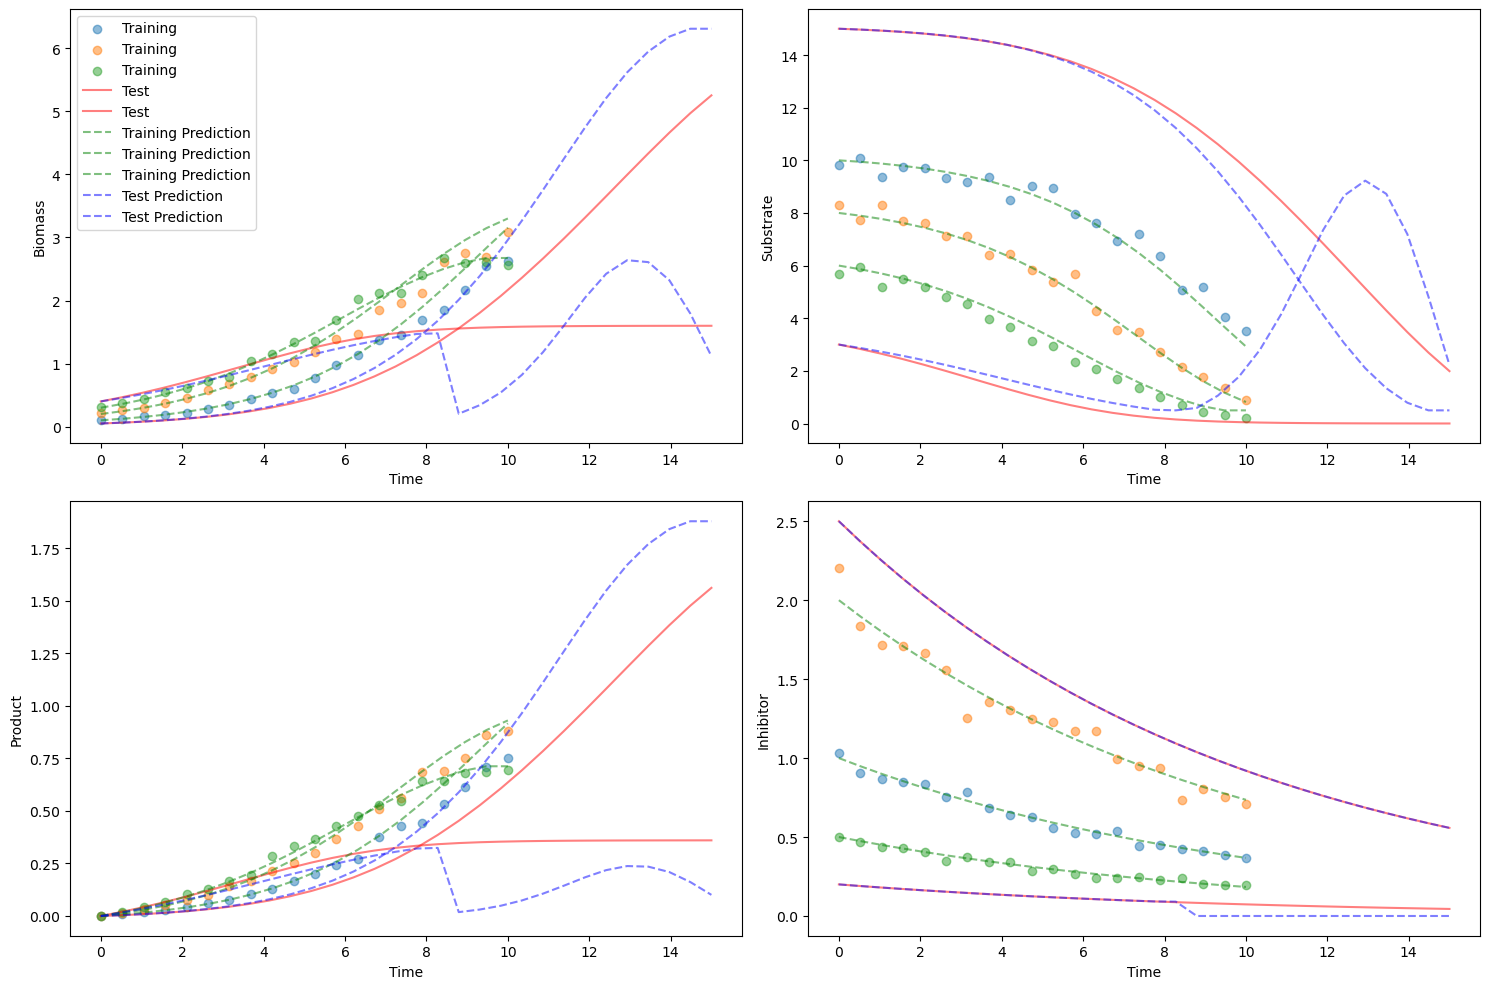

In [13]:
# Example usage:
if __name__ == "__main__":
    # Generate data
    training_data, training_df = generate_training_data()
    test_data = generate_test_data()
    
    # Save training data to CSV (for students)
    training_df.to_csv('training_data.csv', index=False)
    
    # Run genetic algorithm to get solution
    best_individual = genetic_algorithm(training_data)
    
    # Evaluate solution on test data
    rmse, variable_rmse, test_predictions = evaluate_student_solution(
        best_individual["mask"], 
        best_individual["params"], 
        test_data
    )
    
    # Print results
    print("\nChosen Terms:")
    for i, (term, active) in enumerate(zip(term_names, best_individual["mask"])):
        if active:
            print(f"- {term}")
    print("\nBest Parameters:", best_individual["params"])
    print("\nTest Data Performance:")
    print(f"Overall RMSE: {rmse:.4f}")
    print("\nRMSE by variable:")
    for var, error in variable_rmse.items():
        print(f"{var}: {error:.4f}")
    
    # Plot results including test predictions
    plot_results(training_data, test_data, best_individual, test_predictions)